In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import timeit

# Rekursive FFT Implementierung

### Rekursive FFT

In [2]:
def rec_FFT(f):
    """ Recursive FFT calculation of samples f """
    f = np.asarray(f)
    n = f.shape[0]
        
    if n == 1:
        return f
    else:
        f_even = f[::2]
        f_odd = f[1::2]
        g = rec_FFT(f_even)
        u = rec_FFT(f_odd)
        c = np.zeros(n, dtype=complex)
        for k in range(n//2):
            c[k] = g[k] + u[k]*np.exp(-2j*np.pi*k/n)
            c[k+n//2] = g[k] - u[k]*np.exp(-2j*np.pi*k/n)
    return c

### Rekursive FFT mit Berechnung der Sin/Cos Terme ausgelagert

In [3]:
def rk(f):
    """Calculation of rk outside of the FFT for speed up"""
    n = f.shape[0]
    r = np.zeros(n//2, dtype=complex)
    for k in range(n//2):
        r[k] = np.exp(-2j*np.pi*k/n)
    return r

In [4]:
def rec_FFT2(f,r):
    """ Recursive FFT calculation of samples f with calculation of rk outside"""
    f = np.asarray(f)
    n = f.shape[0]
        
    if n == 1:
        return f
    else:
        f_even = f[::2]
        f_odd = f[1::2]
        g = rec_FFT(f_even)
        u = rec_FFT(f_odd)
        c = np.zeros(n, dtype=complex)
        for k in range(n//2):
            c[k] = g[k] + u[k]*r[k]
            c[k+n//2] = g[k] - u[k]*r[k]
    return c

### Inverse rekursive FFT

In [5]:
def IFFT(z):
    """Inverse Recursive FFT calculation of Fourier coefficients z"""
    n = len(z)
    f = IFFT_rec(z)
    return np.real(f)/n

In [6]:
def IFFT_rec(z):
    """  """
    z = np.asarray(z, dtype=complex)
    n = z.shape[0]
    z_even = z[::2]
    z_odd = z[1::2]
    
    if n == 1:
        return z
    else:
        g = IFFT_rec(z_even)
        u = IFFT_rec(z_odd)
        c = np.zeros(n, dtype=complex)
        
        for k in range(n//2):
            temp = u[k]*np.exp(2j*np.pi*k/n)
            c[k]      = g[k] + temp
            c[k+n//2] = g[k] - temp
    return c

# ---------------------------------------------------------------------------------------------------------------
### Test Rekursive FFT

In [7]:
#Abtastung
def sampling(t_end, sampling_freq):
    sampling = np.linspace(0, t_end, t_end * sampling_freq, endpoint=True)
    return sampling

In [8]:
#Sinus Signal
def sine(freq, amp, sampling):
    signal = amp * np.sin(2*np.pi*freq*sampling)
    return signal

In [9]:
def sampling_zweierpot(t_end, f_ab):
    '''erzeugt vektor mit länge einer 2er Potenz'''
    n_samples = f_ab*t_end 
    if np.log2(n_samples) % 1 == 0:
        pass
    else:
        n_samples = 2**(int(np.log2(n_samples))+1)
        
    sampling = np.linspace(0, t_end, n_samples, endpoint=True)
    return sampling

#### Definiere Test Signal bestehend aus harmonischen Funktionen und wende FFT darauf an

In [10]:
# Frequenzen der harmonischen in Testsignal
f1 = 2
f2 = 5
f3 = 8
# Sampling Frequenz festlegen
fs = 10*f3 # sampling frequenz muss mindestens 2*f_max sein!
t_end = 2

In [11]:
time = sampling_zweierpot(t_end, fs)
data1 = sine(f1, 1, time)
data2 = sine(f2, 1, time)
data3 = sine(f3, 1, time)
data = data1 + data2 + data3
Ts = 1/fs

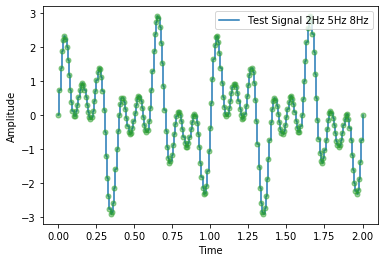

In [12]:
plt.step(time, data, where='post', label= 'Test Signal 2Hz 5Hz 8Hz')
plt.plot(time, data, 'C2o', alpha=0.5, markersize=5)
plt.legend(title='')
plt.xlabel('Time')
plt.ylabel('Amplitude')
#plt.savefig('rec_FFT_Testsignal.eps') #Für Doku/Präsentation
plt.show()

### Plot der Koeffizienten

In [13]:
fft_self = rec_FFT(data)
fft_py = np.fft.fft(data)

In [14]:
fft_schneller = rec_FFT2(data,rk(data))

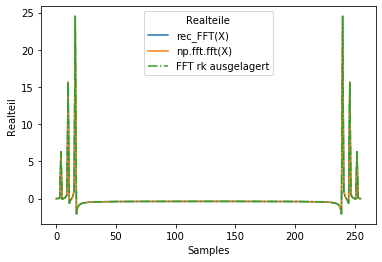

In [15]:
plt.plot(np.real(fft_self),label='rec_FFT(X)')
plt.plot(np.real(fft_py),label='np.fft.fft(X)')
plt.plot(np.real(fft_schneller),'-.',label='FFT rk ausgelagert')
plt.legend(title='Realteile')
plt.xlabel('Samples')
plt.ylabel('Realteil')
#plt.savefig('rec_FFT_Real.eps') #Für Doku/Präsentation
plt.show()

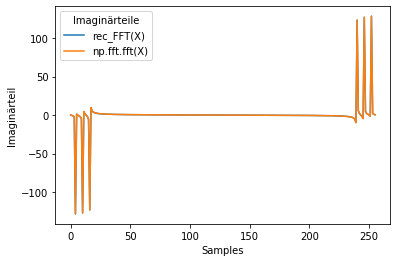

In [16]:
plt.plot(np.imag(fft_self),label='rec_FFT(X)')
plt.plot(np.imag(fft_py),label='np.fft.fft(X)')
plt.legend(title='Imaginärteile')
plt.xlabel('Samples')
plt.ylabel('Imaginärteil')
#plt.savefig('rec_FFT_Imag.eps') #Für Doku/Präsentation
plt.show()

### Differenz Imaginär und Realteil der selbst geschriebenen Funktion und der numpy np.fft.fft()

In [17]:
diff_imag = np.imag(fft_self - fft_py)
diff_real = np.real(fft_self - fft_py)

Text(0, 0.5, 'Differenz')

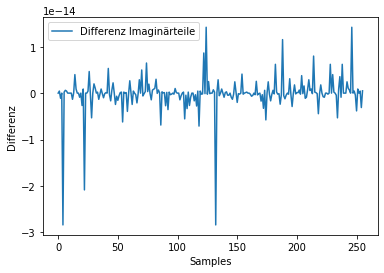

In [18]:
plt.plot(diff_imag,label='Differenz Imaginärteile')
plt.legend(title='')
plt.xlabel('Samples')
plt.ylabel('Differenz')

Text(0, 0.5, 'Differenz')

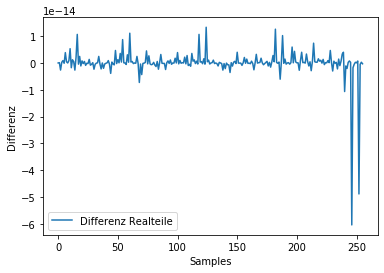

In [19]:
plt.plot(diff_real,label='Differenz Realteile')
plt.legend(title='')
plt.xlabel('Samples')
plt.ylabel('Differenz')

## Inverse FFT (IFFT) Test
Rekonstruiere ursprüngliches Signal mit IFFT(rec_FFT(Data) und berechne die Differenz aus diesem Ergebnis mit dem ursprünglichen Signal Data.

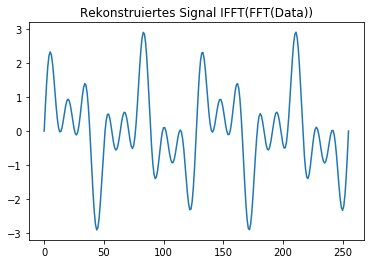

In [20]:
data_rekon = IFFT(rec_FFT(data))
plt.plot(data_rekon)
plt.title('Rekonstruiertes Signal IFFT(FFT(Data))')
plt.show()

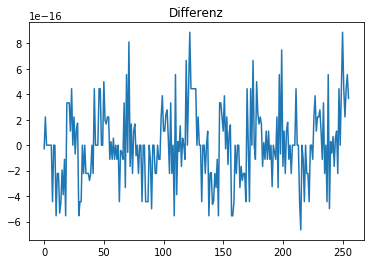

In [21]:
plt.plot(data-data_rekon)
plt.title('Differenz data und IFFT(rec_FFT(data))')
plt.title('Differenz')
plt.show()